In [1]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100, MNIST
from models.cleaner import NoiseCleaner
from models.predictor import Predictor

# Instance Independent

In [2]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='iin', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", folds_num=5, model='resnet18', train_noise_level=0.2, epochs_num=20, transform=transform)

noise count: 12000 out of 60000 data


In [3]:
noise_cleaner.clean()

Training fold 1/5...


Epoch 0/20:   0%|          | 0/20 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [18]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = FashionMNIST(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, model_type='resnet18', batch_size=400, num_epochs=50)

In [ ]:
predictor.train(10)

In [24]:
predictor.evaluate()

Evaluating: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

Test Accuracy: 92.33%


0.9233

# Instance Dependent

## FMnist

In [2]:
train_dataset = FashionMNIST(root='data', train=True, download=False)
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                # transforms.RandomCrop(size=32, padding=4),
                                # transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="fmnist/resnet18/model_resnet18_fmnist_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='wresnet50', train_noise_level=0.2, epochs_num=100, train_pairs=20000, 
                             val_pairs=10000, embedding_dimension=128, lr=1e-3, optimizer='Adam', patience=10, transform=transform,
                             weight_decay=0.0001, training_batch_size=1024, pre_trained=False, dropout_prob=0.2, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce')

Seed: 67
noise count: 12392 out of 60000 data


handling big fold 1/10
number_of_pairs: 4309
Training fold 1/10...


Epoch 10/100:  11%|█         | 11/100 [04:45<38:29, 25.94s/it, val_loss=4.7, val_accuracy=10.6, train_loss=4.7, best_accuracy=10.9]

Early stopping triggered
Loading best model from checkpoint...


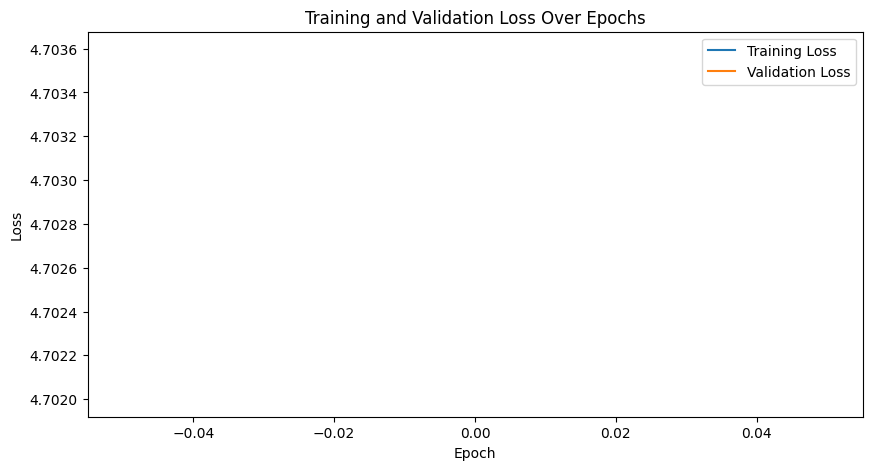

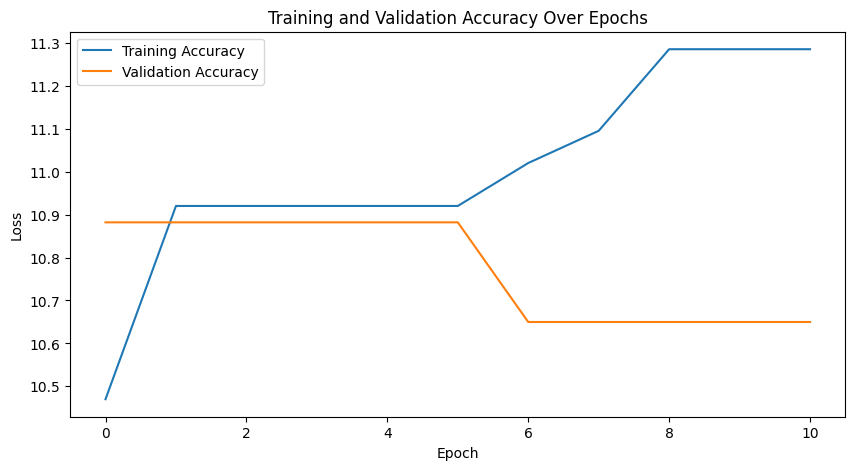

Extracting Embeddings: 100%|██████████| 485/485 [00:06<00:00, 69.79it/s]


Distance between embedding 6589 and 2885: 0.0031
Distance between embedding 6589 and 4016: 0.0037
Distance between embedding 6589 and 5862: 0.0039
Distance between embedding 6589 and 3761: 0.0016
Distance between embedding 6589 and 2201: 0.0011
Distance between embedding 6589 and 6468: 0.0009
Distance between embedding 6589 and 3726: 0.0013
Distance between embedding 6589 and 5161: 0.0011
Distance between embedding 6589 and 1572: 0.0013
Distance between embedding 6589 and 4632: 0.0019
Distance between embedding 6589 and 1639: 0.0010
Distance between embedding 6589 and 399: 0.0013
Distance between embedding 6589 and 1987: 0.0009
Distance between embedding 6589 and 7109: 0.0010
Distance between embedding 6589 and 5832: 0.0011
Distance between embedding 6589 and 6283: 0.0049
Distance between embedding 6589 and 6233: 0.0047
Distance between embedding 6589 and 354: 0.0022
Distance between embedding 6589 and 3924: 0.0028
Distance between embedding 2885 and 4016: 0.0023
Distance between embed

Testing: 100%|██████████| 485/485 [00:06<00:00, 75.06it/s]
/home/aref/.conda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 10.88%
Test Precision: 0.01
Test Recall: 0.11
Test F1 Score: 0.02
Model saved to fmnist/resnet18/model_resnet18_fmnist_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 29/100:  29%|██▉       | 29/100 [12:49<31:24, 26.54s/it, val_loss=3.44, val_accuracy=63.5, train_loss=2.81, best_accuracy=66.8]


KeyboardInterrupt: 

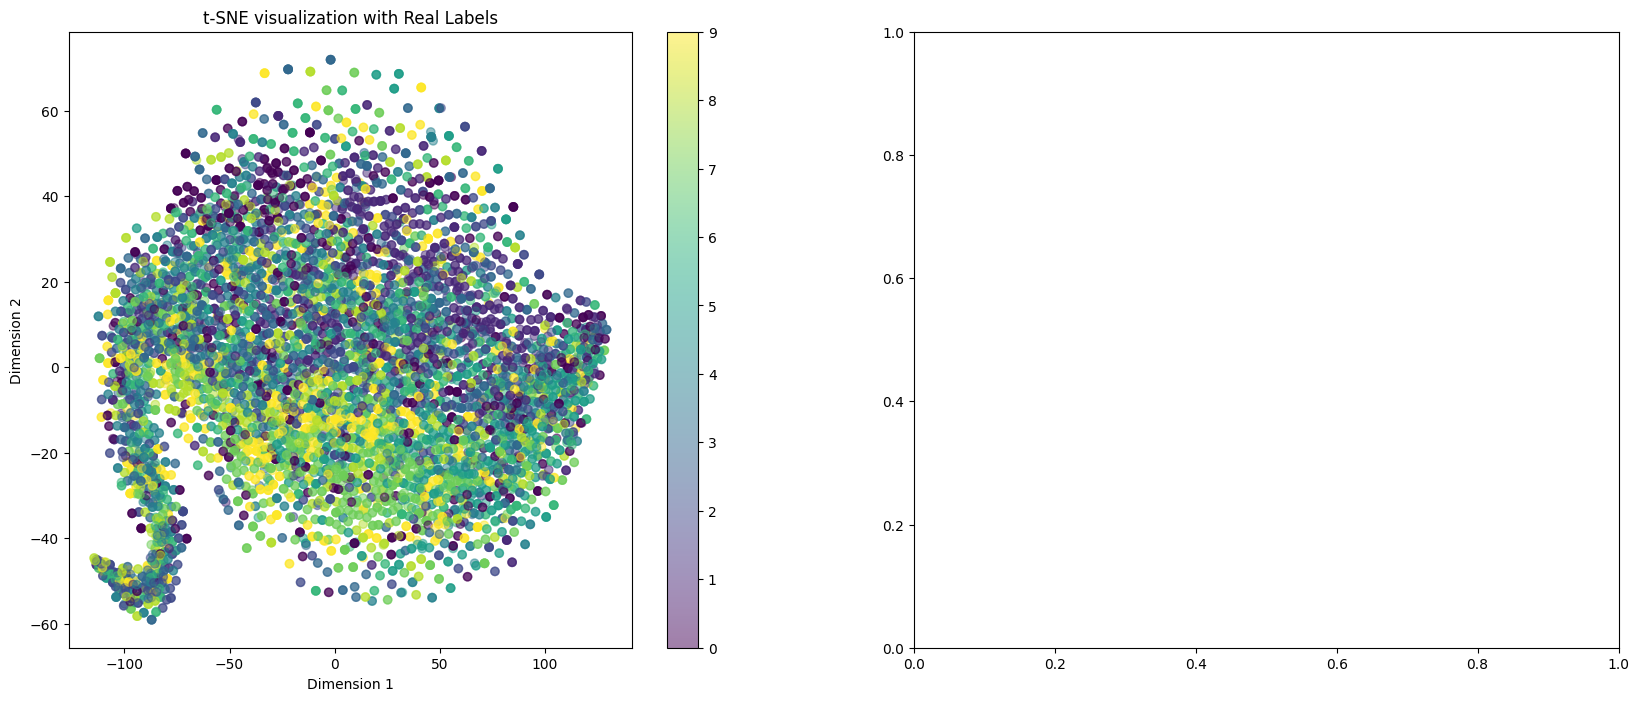

In [3]:
noise_cleaner.clean()

In [257]:
import models.predictor
import models
import importlib
importlib.reload(models)
from models import preact
importlib.reload(preact)
from models import predictor
importlib.reload(predictor)
from models.predictor import Predictor

In [17]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = FashionMNIST(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, model_type='resnet18', batch_size=400)

In [22]:
predictor.train(10)

Training Epoch 1/10: 100%|██████████| 113/113 [01:40<00:00,  1.12it/s]


Validation Accuracy: 93.46%
Epoch 1/10, Loss: 0.24129432162879844


Training Epoch 2/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 96.31%
Epoch 2/10, Loss: 0.12274887458940523


Training Epoch 3/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 97.07%
Epoch 3/10, Loss: 0.08064110191390578


Training Epoch 4/10: 100%|██████████| 113/113 [01:39<00:00,  1.14it/s]


Validation Accuracy: 96.81%
Epoch 4/10, Loss: 0.07340764353233101


Training Epoch 5/10: 100%|██████████| 113/113 [01:39<00:00,  1.14it/s]


Validation Accuracy: 96.51%
Epoch 5/10, Loss: 0.059963096196936294


Training Epoch 6/10: 100%|██████████| 113/113 [01:38<00:00,  1.15it/s]


Validation Accuracy: 97.89%
Epoch 6/10, Loss: 0.0528966288980657


Training Epoch 7/10: 100%|██████████| 113/113 [01:40<00:00,  1.13it/s]


Validation Accuracy: 97.85%
Epoch 7/10, Loss: 0.03885995962582858


Training Epoch 8/10: 100%|██████████| 113/113 [01:40<00:00,  1.13it/s]


Validation Accuracy: 97.95%
Epoch 8/10, Loss: 0.03452066272760915


Training Epoch 9/10: 100%|██████████| 113/113 [01:40<00:00,  1.12it/s]


Validation Accuracy: 98.30%
Epoch 9/10, Loss: 0.030963845262551203


Training Epoch 10/10: 100%|██████████| 113/113 [01:39<00:00,  1.13it/s]


Validation Accuracy: 98.22%
Epoch 10/10, Loss: 0.02610123477282777


In [23]:
predictor.evaluate()

Evaluating: 100%|██████████| 25/25 [00:11<00:00,  2.25it/s]

Test Accuracy: 90.21%


0.9021

## CIFAR 10

In [2]:
train_dataset = CIFAR10(root='data', train=True, download=False)
transform = transforms.Compose([
                                # transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

noise_cleaner = NoiseCleaner(train_dataset, noise_type='idn', model_save_path="cifar10/resnet34/model_resnet34_cifar10_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='resnet50', train_noise_level=0.2, epochs_num=1500, train_pairs=100000, 
                             val_pairs=10000, embedding_dimension=64, lr=1e-3, optimizer='Adam', patience=50, transform=transform,
                             weight_decay=1e-4, training_batch_size=2048, pre_trained=True, dropout_prob=0.55, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.05, loss='ce', margin=2, freeze_epoch=None)

Seed: 84
noise count: 10136 out of 50000 data


handling big fold 1/10
number_of_pairs: 3591
Training fold 1/10...


Epoch 62/1500:   4%|▍         | 63/1500 [1:35:23<36:15:40, 90.84s/it, val_loss=4.7, val_contrastive=1.12, val_accuracy=57.4, train_loss=1.46, train_contrastive=0.75, best_accuracy=66.2, best_loss=3.73]  

Early stopping triggered
Loading best model from checkpoint...


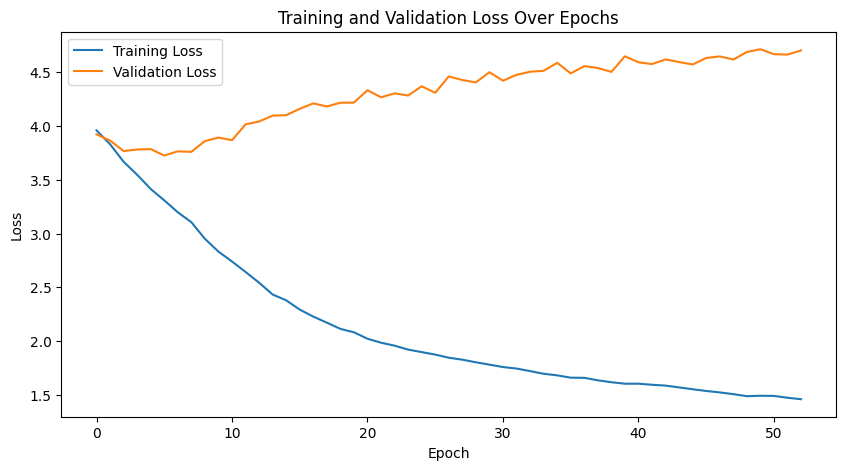

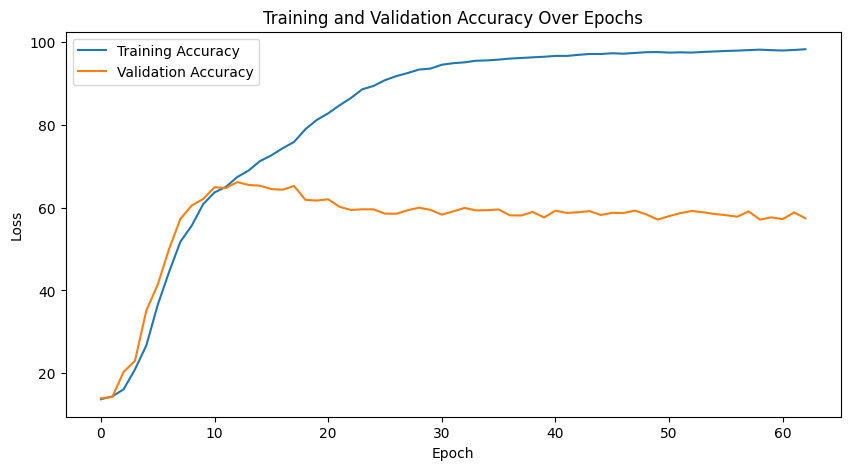

Extracting Embeddings: 100%|██████████| 404/404 [00:04<00:00, 80.92it/s]


Distance between embedding 1099 and 1329: 1.2384
Distance between embedding 1099 and 2507: 1.2308
Distance between embedding 1099 and 5849: 1.2680
Distance between embedding 1099 and 5825: 1.1427
Distance between embedding 1099 and 1631: 1.1517
Distance between embedding 1099 and 6069: 1.0862
Distance between embedding 1099 and 4772: 1.3061
Distance between embedding 1099 and 2898: 0.7741
Distance between embedding 1099 and 4307: 1.2063
Distance between embedding 1099 and 4039: 0.7644
Distance between embedding 1099 and 3893: 1.4550
Distance between embedding 1099 and 693: 1.0955
Distance between embedding 1099 and 1431: 0.9552
Distance between embedding 1099 and 6454: 0.9152
Distance between embedding 1099 and 5256: 1.2992
Distance between embedding 1099 and 2889: 0.7656
Distance between embedding 1099 and 703: 1.1101
Distance between embedding 1099 and 532: 1.0377
Distance between embedding 1099 and 2178: 0.6284
Distance between embedding 1329 and 2507: 1.3647
Distance between embedd

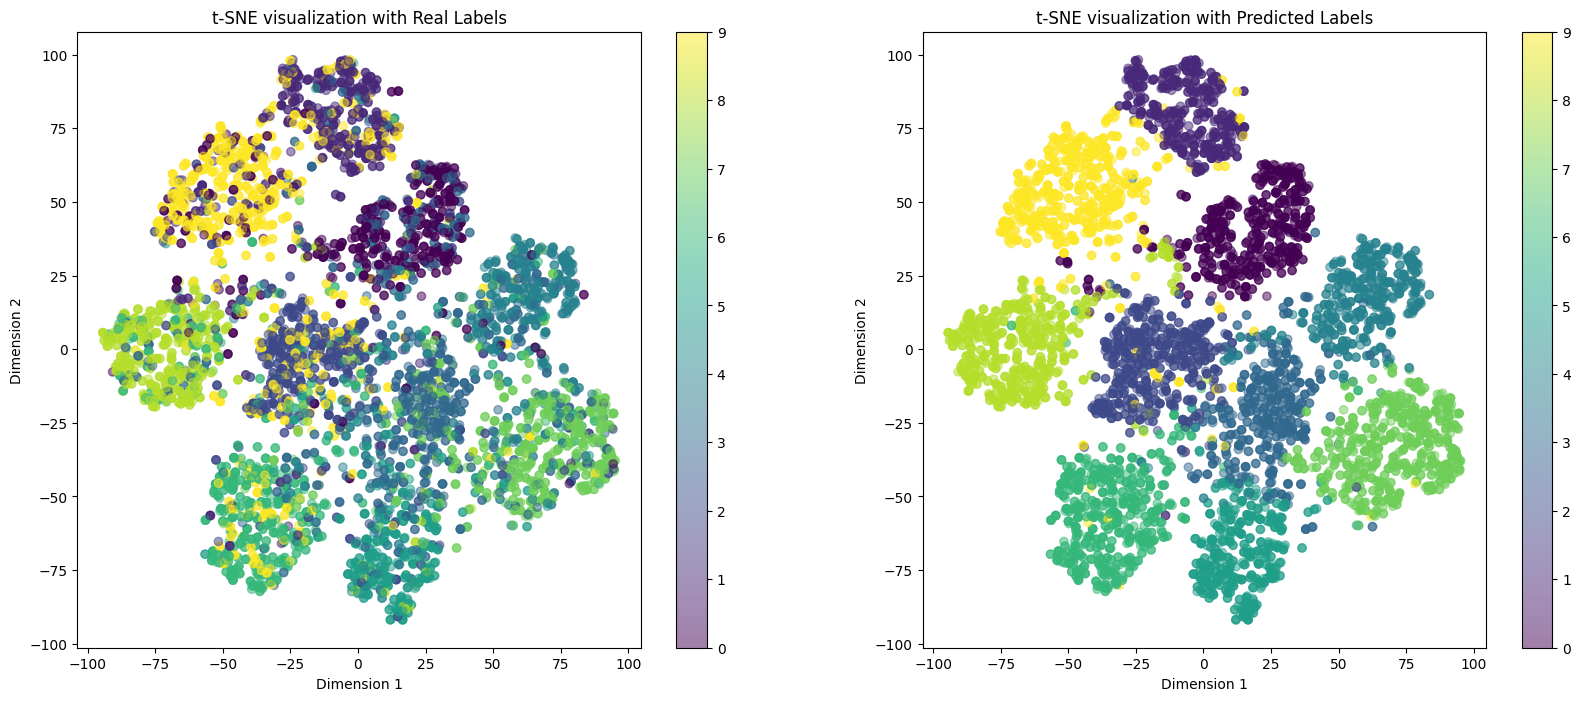

value counts for predicted:
[[  0 660]
 [  1 535]
 [  2 674]
 [  3 581]
 [  4 590]
 [  5 519]
 [  6 704]
 [  7 750]
 [  8 691]
 [  9 760]]
value counts for real:
[[  0 629]
 [  1 502]
 [  2 605]
 [  3 902]
 [  4 618]
 [  5 461]
 [  6 631]
 [  7 670]
 [  8 507]
 [  9 939]]


Testing: 100%|██████████| 404/404 [00:04<00:00, 85.10it/s]


Test Accuracy: 66.17%
Test Precision: 0.66
Test Recall: 0.66
Test F1 Score: 0.66
Model saved to cifar10/resnet34/model_resnet34_cifar10_fold_1.pth
Finished training fold 1
Training fold 2/10...


Epoch 78/1500:   5%|▌         | 79/1500 [1:59:47<35:54:52, 90.99s/it, val_loss=4.56, val_contrastive=1.12, val_accuracy=59.7, train_loss=1.71, train_contrastive=0.883, best_accuracy=67, best_loss=3.65]


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 404/404 [00:04<00:00, 85.85it/s]


Test Accuracy: 66.96%
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.67
Model saved to cifar10/resnet34/model_resnet34_cifar10_fold_2.pth
Finished training fold 2
Training fold 3/10...


Epoch 59/1500:   4%|▍         | 60/1500 [1:30:59<36:23:40, 90.99s/it, val_loss=4.59, val_contrastive=1.12, val_accuracy=59.3, train_loss=1.39, train_contrastive=0.7, best_accuracy=67.4, best_loss=3.73]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 404/404 [00:04<00:00, 85.77it/s]


Test Accuracy: 67.36%
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.67
Model saved to cifar10/resnet34/model_resnet34_cifar10_fold_3.pth
Finished training fold 3
Training fold 4/10...


Epoch 50/1500:   3%|▎         | 51/1500 [1:17:04<36:29:52, 90.68s/it, val_loss=6.56, val_contrastive=2, val_accuracy=14.1, train_loss=6.56, train_contrastive=2, best_accuracy=16.7, best_loss=5.88]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 404/404 [00:04<00:00, 85.26it/s]
/home/aref/.conda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 16.74%
Test Precision: 0.08
Test Recall: 0.17
Test F1 Score: 0.08
Model saved to cifar10/resnet34/model_resnet34_cifar10_fold_4.pth
Finished training fold 4
Training fold 5/10...


Epoch 67/1500:   5%|▍         | 68/1500 [1:42:58<36:08:40, 90.87s/it, val_loss=4.62, val_contrastive=1.1, val_accuracy=58.3, train_loss=1.53, train_contrastive=0.802, best_accuracy=67, best_loss=3.6] 


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 404/404 [00:04<00:00, 85.24it/s]


Test Accuracy: 67.02%
Test Precision: 0.67
Test Recall: 0.67
Test F1 Score: 0.67
Model saved to cifar10/resnet34/model_resnet34_cifar10_fold_5.pth
Finished training fold 5
Training fold 6/10...


Epoch 59/1500:   4%|▍         | 60/1500 [1:31:07<36:26:51, 91.12s/it, val_loss=4.74, val_contrastive=1.13, val_accuracy=59, train_loss=1.41, train_contrastive=0.712, best_accuracy=66.3, best_loss=3.79]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 404/404 [00:04<00:00, 81.50it/s]


Test Accuracy: 66.26%
Test Precision: 0.67
Test Recall: 0.66
Test F1 Score: 0.66
Model saved to cifar10/resnet34/model_resnet34_cifar10_fold_6.pth
Finished training fold 6
Training fold 7/10...


Epoch 50/1500:   3%|▎         | 51/1500 [1:17:02<36:28:48, 90.63s/it, val_loss=6.56, val_contrastive=2, val_accuracy=14.6, train_loss=6.56, train_contrastive=2, best_accuracy=15.6, best_loss=5.88]  


Early stopping triggered
Loading best model from checkpoint...


Testing: 100%|██████████| 404/404 [00:04<00:00, 84.20it/s]
/home/aref/.conda/envs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 15.64%
Test Precision: 0.12
Test Recall: 0.16
Test F1 Score: 0.07
Model saved to cifar10/resnet34/model_resnet34_cifar10_fold_7.pth
Finished training fold 7
Training fold 8/10...


Epoch 28/1500:   2%|▏         | 28/1500 [42:54<37:35:51, 91.95s/it, val_loss=4.17, val_contrastive=1.13, val_accuracy=58.8, train_loss=2.26, train_contrastive=1.14, best_accuracy=65.7, best_loss=3.72]


KeyboardInterrupt: 

In [3]:
noise_cleaner.clean()

In [4]:
import torch
import torch.functional as F
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torchvision.models import vgg19_bn, VGG19_BN_Weights
from models.preact import *
from models.cnn import CustomCNN
from models.dla import DLA
from torchsummary import summary

pre_trained = True
base_model = nn.Sequential(
                nn.Conv2d(3, 32, 3, stride=1, padding=1),  #out ->  b, 16, 14, 14
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),  #out -> b, 16, 8, 8
                
                nn.Conv2d(32, 64, 3, stride=1, padding=1),  #out -> b, 8, 8, 8
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  #out -> b, 8, 5, 5
                nn.Flatten(),
                
                nn.Linear(5184, 256),
                nn.ReLU(),
                )
base_model.fc = nn.Flatten()

base_model = base_model.cuda()
if hasattr(base_model, 'fc'):
    base_model.fc = nn.Flatten()
    feature_extractor = base_model
else:
    feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
summary(feature_extractor, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 9, 9]               0
           Flatten-7                 [-1, 5184]               0
            Linear-8                  [-1, 256]       1,327,360
              ReLU-9                  [-1, 256]               0
          Flatten-10                  [-1, 256]               0
Total params: 1,346,752
Trainable params: 1,346,752
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.90
Params size (MB): 5.14
Estimat

## New Expreiment

In [1]:
from models.vae import *  # Import your custom VAE model and loss
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models.dataset import CustomDataset  # Assuming CustomDataset is custom-made

# Define transformations with augmentations
augmented_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(size=64, padding=4),  # Random cropping with padding
    transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10),  # AutoAugment for CIFAR10
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 3 channels to match input
    transforms.ToTensor()  # Convert to tensor
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='data', train=True, download=False)

# Wrap the CIFAR10 dataset using CustomDataset (assuming it's necessary)
dataset = CustomDataset(train_dataset, transform=augmented_transform)

# DataLoader with batch size and shuffling (shuffle=True for training)
train_loader = DataLoader(dataset, batch_size=800, shuffle=True)

# Initialize the VAE loss function (MSE reconstruction loss)
vae_loss_fn = VAELoss(reconstruction_loss_type="mse")

# Define VAE parameters
latent_dim = 20
hidden_dim = 256
output_dim = 32*32  # Output feature dimension from ResNet18

# Initialize the VAE model
vae = VAE(latent_dim)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = vae.to(device)

# Optimizer (Adam)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop function
def train(epoch):
    vae.train()  # Set the model to training mode
    train_loss = 0  # Track the total loss
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Move the data to the GPU if available
        optimizer.zero_grad()  # Reset the gradients
        recon_batch, mu, logvar = vae(data)  # Forward pass through VAE
        loss = vae_loss_fn(recon_batch, data, mu, logvar)  # Calculate VAE loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()  # Accumulate the loss
        optimizer.step()  # Update model parameters

    # Print the average loss for the epoch
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

# Train the VAE model for 10 epochs
for epoch in range(1, 11):
    train(epoch)

Epoch 1, Loss: 116613.89822875
Epoch 2, Loss: 652.5716528125
Epoch 3, Loss: 568.0243871875
Epoch 4, Loss: 514.767764375
Epoch 5, Loss: 486.0452425
Epoch 6, Loss: 462.51460625
Epoch 7, Loss: 445.3024959375
Epoch 8, Loss: 435.4643065625
Epoch 9, Loss: 421.8742640625
Epoch 10, Loss: 410.498935625


In [10]:
for epoch in range(11, 251):
    train(epoch)

Epoch 11, Loss: 201.806855
Epoch 12, Loss: 202.6633796875
Epoch 13, Loss: 201.838084375
Epoch 14, Loss: 201.56012296875
Epoch 15, Loss: 201.4204365625
Epoch 16, Loss: 200.68404078125
Epoch 17, Loss: 201.663695
Epoch 18, Loss: 200.3300196875
Epoch 19, Loss: 199.64572921875
Epoch 20, Loss: 199.5438884375
Epoch 21, Loss: 200.0736596875
Epoch 22, Loss: 199.000961875
Epoch 23, Loss: 198.2702909375
Epoch 24, Loss: 198.83876625
Epoch 25, Loss: 198.64641234375
Epoch 26, Loss: 198.174250625
Epoch 27, Loss: 198.654705
Epoch 28, Loss: 197.083101875
Epoch 29, Loss: 197.42817328125
Epoch 30, Loss: 198.018560625
Epoch 31, Loss: 198.42947609375
Epoch 32, Loss: 197.05003609375
Epoch 33, Loss: 196.3795140625
Epoch 34, Loss: 196.21175421875
Epoch 35, Loss: 195.6715984375
Epoch 36, Loss: 195.1604253125
Epoch 37, Loss: 194.5808478125
Epoch 38, Loss: 194.105665625
Epoch 39, Loss: 193.917190625
Epoch 40, Loss: 194.8503015625
Epoch 41, Loss: 194.7926415625
Epoch 42, Loss: 194.34278609375
Epoch 43, Loss: 193.

KeyboardInterrupt: 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

def extract_embeddings(vae: VAE, dataloader, device):
    vae.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            z = vae.latent_embedding(data)
            embeddings.append(z.cpu().numpy())
            labels.append(targets.numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

def apply_tsne(embeddings):
    tsne = TSNE(n_components=2, random_state=0)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

def plot_embeddings(embeddings_2d, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('2D t-SNE of VAE Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()


In [11]:
embeddings, labels = extract_embeddings(vae, train_loader, device)
embeddings_2d = apply_tsne(embeddings)
plot_embeddings(embeddings_2d, labels)

KeyboardInterrupt: 

## Animal10N

In [2]:
from models.dataset import Animal10NDataset
from models.siamese_tester import SiameseTester
from models.siamese import *
from models.predefined import InstanceDependentNoiseAdder
from torchvision import transforms
from torchvision.datasets import FashionMNIST, CIFAR10, CIFAR100, MNIST
from models.cleaner import NoiseCleaner
from models.predictor import Predictor

train_dataset = Animal10NDataset('data/Animal10N/training')
test_dataset = Animal10NDataset('data/Animal10N/testing')
transform = transforms.Compose([
                                #transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                transforms.RandomCrop(size=64, padding=4),
                                #transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
noise_cleaner = NoiseCleaner(train_dataset, noise_type='none', model_save_path="cifar10/resnet34/model_resnet34_cifar10_fold_{}.pth", 
                             inner_folds_num=10, outer_folds_num=10, model='vgg19-bn', train_noise_level=0, epochs_num=500, train_pairs=200000, 
                             val_pairs=10000, embedding_dimension=128, lr=1e-3, optimizer='Adam', patience=7, transform=transform,
                             weight_decay=0.0005, training_batch_size=450, pre_trained=False, dropout_prob=0.2, contrastive_ratio=1,
                             distance_meter='euclidian', augmented_transform=augmented_transform, trainable=True, pair_validation=False,
                             label_smoothing=0.1, loss='ce', cnn_size=None)

In [ ]:
noise_cleaner.clean()

Seed: 74


Epoch 17/50:  32%|███▏      | 16/50 [00:40<01:25,  2.52s/it, train_loss=4.99, val_loss=4.96, val_accuracy=12.8]

Early stopping triggered
Loading best model from checkpoint...
best accuracy: 12.75


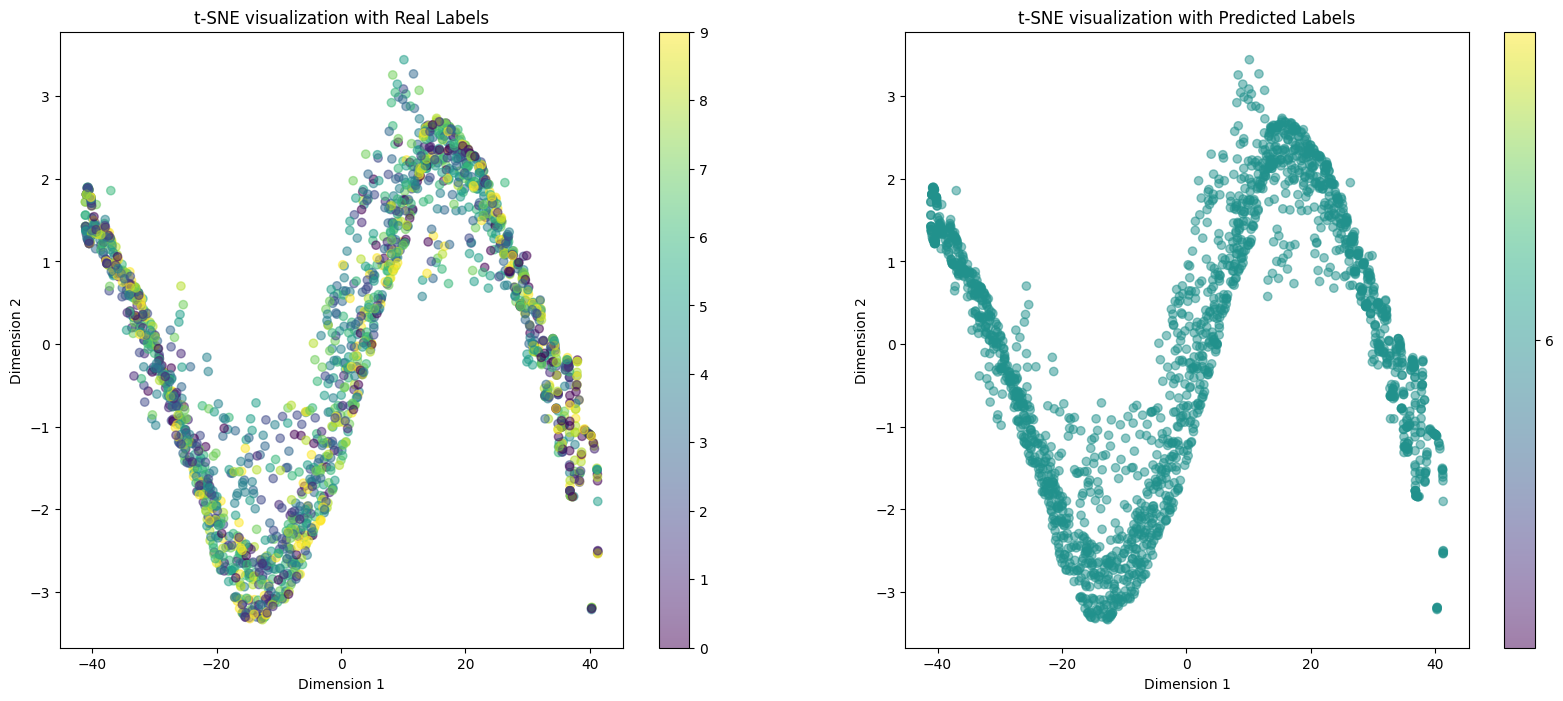

In [5]:
from models.siamese_tester import SiameseTester
from models.siamese import *
from models.predefined import InstanceDependentNoiseAdder

transform = transforms.Compose([                                
                                transforms.RandomCrop(size=32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
augmented_transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])
train_dataset = CIFAR10(root='data', train=True, download=False)
train_noise_adder = InstanceDependentNoiseAdder(train_dataset, image_size=3072, ratio=0.2, num_classes=10)
train_noise_adder.add_noise()
tester = SiameseTester(train_dataset, SiameseNetwork, transform=transform, augmented_transform=augmented_transform)
tester.train(50)

In [258]:
transform = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor()])

In [259]:
clean_train_dataset = noise_cleaner.clean_dataset
test_dataset = CIFAR10(root='data', train=False, download=False)
predictor = Predictor(train_dataset=clean_train_dataset, test_dataset=test_dataset, transform=transform, num_classes=10, 
                      model_type='resnet18', batch_size=2048, pre_trained=True, weight_decay=0.0005)

In [ ]:
predictor.train(120)

In [267]:
predictor.evaluate()

Evaluating: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]

Test Accuracy: 77.23%


0.7723

In [119]:
predictor.free_model()

In [ ]:
for i in range(5):
    predictor.train(2)
    predictor.evaluate()